In [1]:
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()

Saving CarPrice_Assignment_Simple.csv to CarPrice_Assignment_Simple.csv


In [2]:
cars = pd.read_csv(io.BytesIO(uploaded['CarPrice_Assignment_Simple.csv']))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn' (to supress warning in outlier treatment capping)
np.seterr(divide='ignore') #Ignore runtime warning in VIF (for division of zero)
pd.options.display.max_rows = 4000  #(For avoiding results geting truncated)

In [4]:
# summary of the dataset: 205 rows, 8 columns, no null values
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   car_ID      205 non-null    int64  
 1   drivewheel  205 non-null    object 
 2   carlength   205 non-null    float64
 3   carwidth    205 non-null    float64
 4   carheight   205 non-null    float64
 5   curbweight  205 non-null    int64  
 6   horsepower  205 non-null    int64  
 7   price       205 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 12.9+ KB
None


In [5]:
#Get number of rows and columns in the dataset
cars.shape

(205, 8)

In [6]:
cars.head(5)
#rwd=rear wheel drive, fwd=forward wheel drive and 4wd=4 wheel drive

,car_ID,drivewheel,carlength,carwidth,carheight,curbweight,horsepower,price
0,1,rwd,168.8,64.1,48.8,2548,111,13495.0
1,2,rwd,168.8,64.1,48.8,2548,111,16500.0
2,3,rwd,171.2,65.5,52.4,2823,154,16500.0
3,4,fwd,176.6,66.2,54.3,2337,102,13950.0
4,5,4wd,176.6,66.4,54.3,2824,115,17450.0


In [7]:
#Lets Cast Car ID as category (always convert IDs to categorical variables)
cars['car_ID'] = cars['car_ID'].astype('object')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   car_ID      205 non-null    object 
 1   drivewheel  205 non-null    object 
 2   carlength   205 non-null    float64
 3   carwidth    205 non-null    float64
 4   carheight   205 non-null    float64
 5   curbweight  205 non-null    int64  
 6   horsepower  205 non-null    int64  
 7   price       205 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 12.9+ KB


Build Data Understanding

In [8]:
# drivewheel: frontwheel, rarewheel or four-wheel drive
cars['drivewheel'].value_counts()

#Takeaway: Looks like "4wd" drive car are rare

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

In [9]:
cars.groupby('drivewheel')['price'].agg('mean').round(decimals=2)
#Google: which car is more expensive forward wheel or rear wheel drive

drivewheel
4wd    11087.46
fwd     9239.31
rwd    19910.81
Name: price, dtype: float64

In [10]:
# all numeric (float and int) variables in the dataset
cars_numeric = cars.select_dtypes(include=['float64', 'int64'])
cars_numeric.head()

,carlength,carwidth,carheight,curbweight,horsepower,price
0,168.8,64.1,48.8,2548,111,13495.0
1,168.8,64.1,48.8,2548,111,16500.0
2,171.2,65.5,52.4,2823,154,16500.0
3,176.6,66.2,54.3,2337,102,13950.0
4,176.6,66.4,54.3,2824,115,17450.0


In [11]:
# correlation matrix
cor = cars_numeric.corr()
cor.round(2)

,carlength,carwidth,carheight,curbweight,horsepower,price
carlength,1.00,0.84,0.49,0.88,0.55,0.68
carwidth,0.84,1.00,0.28,0.87,0.64,0.76
carheight,0.49,0.28,1.00,0.30,-0.11,0.12
curbweight,0.88,0.87,0.30,1.00,0.75,0.84
horsepower,0.55,0.64,-0.11,0.75,1.00,0.81
price,0.68,0.76,0.12,0.84,0.81,1.00


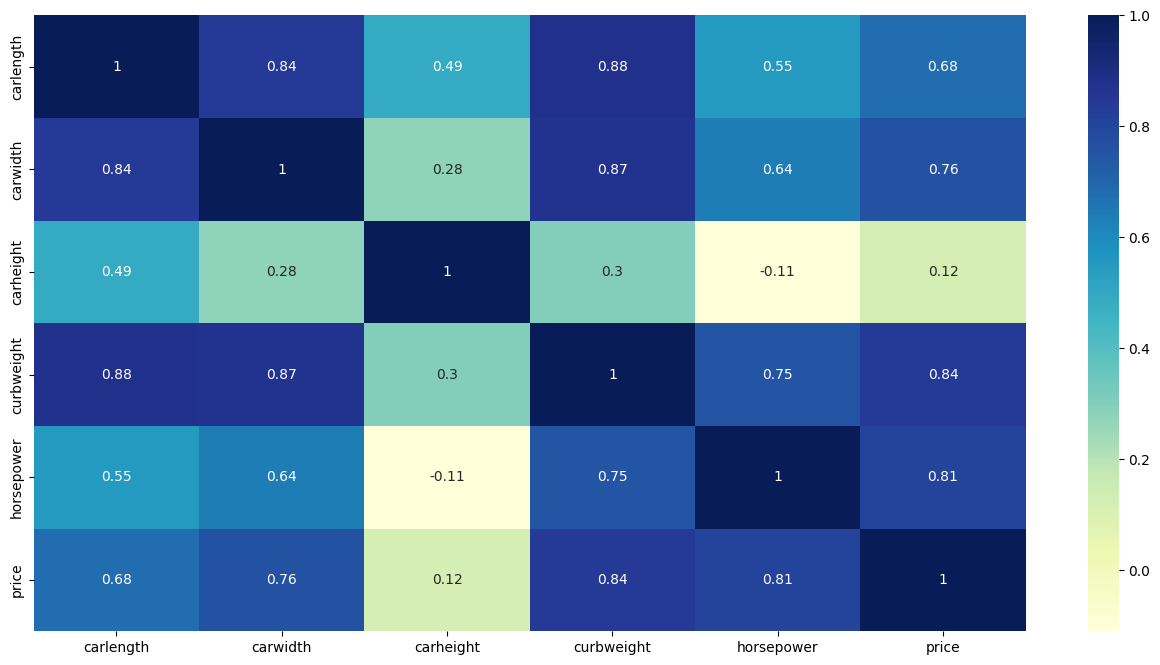

In [12]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap: 1
#sns.heatmap(cor)
# heatmap: 2
#sns.heatmap(cor, cmap="YlGnBu")
# heatmap: 3
sns.heatmap(cor.round(2), cmap="YlGnBu", annot=True)
plt.show()


# **Data Preparation**

In [13]:
cars.columns

Index(['car_ID', 'drivewheel', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'horsepower', 'price'],
      dtype='object')

In [14]:
# split into X and y (do not select "Car ID")
#iloc, loc
X = cars.loc[:, ['drivewheel', 'carlength', 'carwidth', 'carheight','curbweight', 'horsepower']]

Y  = cars['price']

In [15]:
X.head()

,drivewheel,carlength,carwidth,carheight,curbweight,horsepower
0,rwd,168.8,64.1,48.8,2548,111
1,rwd,168.8,64.1,48.8,2548,111
2,rwd,171.2,65.5,52.4,2823,154
3,fwd,176.6,66.2,54.3,2337,102
4,4wd,176.6,66.4,54.3,2824,115


In [16]:
Y.head()

0    13495.0
1    16500.0
2    16500.0
3    13950.0
4    17450.0
Name: price, dtype: float64

**Dummy Variable Creation**

In [17]:
# creating dummy variables for categorical variables

# subset all categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()

,drivewheel
0,rwd
1,rwd
2,rwd
3,fwd
4,4wd


In [18]:
#checking unique values in "drive wheel" column
cars_categorical['drivewheel'].unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

In [19]:
# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()

,drivewheel_fwd,drivewheel_rwd
0,0,1
1,0,1
2,0,1
3,1,0
4,0,0


In [20]:
list(cars_categorical.columns)

['drivewheel']

In [21]:
# drop categorical variables
X = X.drop(list(cars_categorical.columns), axis=1)

# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)

In [22]:
X.head()

,carlength,carwidth,carheight,curbweight,horsepower,drivewheel_fwd,drivewheel_rwd
0,168.8,64.1,48.8,2548,111,0,1
1,168.8,64.1,48.8,2548,111,0,1
2,171.2,65.5,52.4,2823,154,0,1
3,176.6,66.2,54.3,2337,102,1,0
4,176.6,66.4,54.3,2824,115,0,0


**Model Building: splitting data in test and train**

In [23]:
# fitting a linear model
import statsmodels.api as sm

#adding a constant
X = sm.add_constant(X)

In [24]:
X.head()

,const,carlength,carwidth,carheight,curbweight,horsepower,drivewheel_fwd,drivewheel_rwd
0,1.0,168.8,64.1,48.8,2548,111,0,1
1,1.0,168.8,64.1,48.8,2548,111,0,1
2,1.0,171.2,65.5,52.4,2823,154,0,1
3,1.0,176.6,66.2,54.3,2337,102,1,0
4,1.0,176.6,66.4,54.3,2824,115,0,0


In [25]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,test_size = 0.2, random_state=100)

In [26]:
X_train.shape

(164, 8)

In [27]:
X_test.shape

(41, 8)

In [28]:
Y_train.shape

(164,)

In [29]:
Y_test.shape

(41,)

**Model Building : Fitting Linear Model**

In [30]:
#performing the regression
#OLS = Ordinary Least Square
model = sm.OLS(Y_train,X_train).fit()

In [31]:
# Result of statsmodels
# OLS = Ordinary least squares
#No. Observations = Number of obeservations in train data = 164
#Df residuals = n - (k+1) = 164 - (df model +1)
#df model = In general equals to number of variables
#"const" term: The constant terms is the intercept of the regression line
# std error: std err reflects the level of accuracy of the coefficients. The lower it is, the higher is the level of accuracy
# t value: (coef/SD)
# P >|t| is your p-value. A p-value of less than 0.05 is considered to be statistically significant (Variable is important) else variable is not imp)
# Confidence Interval represents the range in which our coefficients are likely to fall (with a likelihood of 95%)


#More details on how to read these results: https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/#:~:text=Degree%20of%20freedom(df)%20of,sum%20of%20squares%20is%20calculated.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     93.78
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.27e-52
Time:                        07:24:05   Log-Likelihood:                -1564.3
No. Observations:                 164   AIC:                             3145.
Df Residuals:                     156   BIC:                             3169.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -5.28e+04   1.57e+04     -3.

In [32]:
from statsmodels.tools.eval_measures import rmse
# fit your model which you have already done

# now generate predictions
ypred_train = model.predict(X_train)

# calc rmse
rmse_train = rmse(Y_train, ypred_train)
rmse_train

3359.9854183722814

In [33]:
X_train.head()

,const,carlength,carwidth,carheight,curbweight,horsepower,drivewheel_fwd,drivewheel_rwd
3,1.0,176.6,66.2,54.3,2337,102,1,0
157,1.0,166.3,64.4,52.8,2109,70,1,0
81,1.0,173.0,65.4,49.4,2328,88,1,0
32,1.0,150.0,64.0,52.6,1837,60,1,0
99,1.0,173.4,65.2,54.7,2324,97,1,0


In [34]:
Y_train.head()

3      13950.0
157     7198.0
81      8499.0
32      5399.0
99      8949.0
Name: price, dtype: float64

In [35]:
# concat actual values with predicted values
Y_actual_vs_predicted = pd.concat([Y_train, ypred_train], axis=1)
Y_actual_vs_predicted.columns = ['actual_price','predicted_price']

In [ ]:
Y_actual_vs_predicted.head()

,actual_price,predicted_price
3,13950.0,11098.960221
157,7198.0,6804.277159
81,8499.0,8914.812373
32,5399.0,5783.233476
99,8949.0,10300.445774


In [ ]:
#Lets download the file and check what is our root mean squared error
Y_actual_vs_predicted.to_csv('Y_actual_vs_predicted.csv')
files.download('Y_actual_vs_predicted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
#mae = Mean absolute error
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

print(mae(Y_train, ypred_train))

2343.870107028426


In [37]:
# now generate predictions on test data
ypred_test = model.predict(X_test)

# calc rmse
rmse_test = rmse(Y_test, ypred_test.round(1))
rmse_test

#Train: 3359


#Training acc >> Test Acc ------------> Overfit
#Training acc ~ Test acc -------------> Best fit
# Train and test both acc are low ----> Underfit

4690.614267303819

In [42]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, ypred_test)
r2

0.7144060893497479

In [43]:
from sklearn.metrics import r2_score
r2_train = r2_score(Y_train, ypred_train)
r2_train

0.8079985826626453